In [1]:
from typing import Dict, List
from ddnn.nn import *
from ddnn.data import *
from ddnn.validation import *

In [2]:
net = NeuralNetwork(
    [
        LinearLayer((8, 16)),
        ActivationFunction(),
        LinearLayer((16, 16)),
        ActivationFunction(),
        LinearLayer((16, 2)),
    ]
)
estimator = Estimator(net) # fix to work without anything
grid = {}
grid["layers"] = [[(4, "ReLU"), (1, "logistic")]]
grid["learning_rate"] = [0.5, 0.6]
grid["momentum_coefficient"] = [0.9]
grid["optimizer"] = ["SGD"]
grid["loss"] = ["MSE"]
grid["l2_coefficient"] = [1e-3, 1e-4, 1e-5]
grid["batchsize"] = [-1, 16]
grid["weight_initializer"] = ["random_uniform"]
# grid['fan_mode'] = ['fan_in', 'fan_out']
selector = GridSearch(estimator, grid, 123)

In [3]:
# data = read_ML_cup("train")
data = read_monks(1, "train")
data = onehot_encoding(data=data)

In [4]:
logger = Logger(estimator, ["MSE", "binary_accuracy"], every=5)

In [5]:
selector.k_fold(
    data,
    5,
    n_epochs=2000,
    loss_list=["MSE"],
    early_stopping=(10, 10),
    seed=123,
    on_fold_change=logger.update_fold,
    on_hp_change=logger.update_hp,
    training_callback=logger,
);

{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.001, 'batchsize': -1, 'weight_initializer': 'random_uniform'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.001, 'batchsize': 16, 'weight_initializer': 'random_uniform'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.0001, 'batchsize': -1, 'weight_initializer': 'random_uniform'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 0.0001, 'batchsize': 16, 'weight_initializer': 'random_uniform'}
{'layers': [(4, 'ReLU'), (1, 'logistic')], 'learning_rate': 0.5, 'momentum_coefficient': 0.9, 'optimizer': 'SGD', 'loss': 'MSE', 'l2_coefficient': 1e-05, 

In [6]:
from ipywidgets.widgets import interact_manual, interact
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from textwrap import wrap

interactive(children=(Dropdown(description='loss', options=('MSE', 'binary_accuracy'), value='MSE'), Dropdown(…

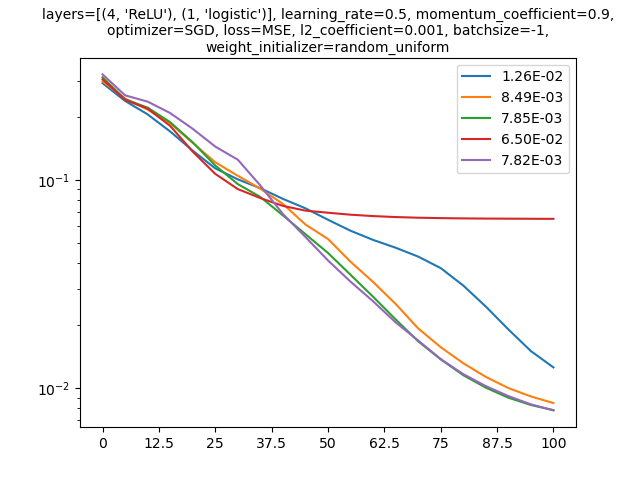

In [7]:
%matplotlib ipympl

hps = [x["hp"] for x in logger._scores]
fig, ax = plt.subplots()

@interact(
    loss = logger._losses,
    hyper = hps,
    where = ["train", "valid"]
)
def plot_results(loss, hyper, where):
    ys = [y[where][loss] for y in logger._scores[hps.index(hyper)]["folds"]]
    if loss != "binary_accuracy":
        bests = [min(y) for y in ys]
        form = "{:.2E}"
        logplot = True
    else:
        bests = [max(y) for y in ys]
        form = "{:.2}"
        logplot = False

    ax.clear()
    ax.set_title(", ".join([f"{k}={v}" for k,v in hyper.items()]), wrap=True, fontsize=10)
    # scale to resemble number of epochs instead of plot points
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*logger._every))
    ax.xaxis.set_major_formatter(ticks_x)
    if logplot:
        ax.set_yscale("log")
    else:
        ax.set_yscale("linear")
    for y,best in zip(ys, bests):
        ax.plot(y, label=f"{form.format(best)}")
    ax.legend()